In [1]:
from argparse import ArgumentParser
import keras
from keras import backend as K
import os
from os import walk
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import tensorflow as tf
import pickle

size = 128

def load_filenames(data_path, val_cases = {}):
    filenames = []
    for (dirpath, dirnames, filenames) in walk(data_path.format('x')):
        filenames.extend(filenames)
        break
    training_filenames = []
    validation_filenames = []
    for f in filenames:
        case = int(f.split('case')[1].split('_')[0])
        if '.npy' not in f:
            continue
        if case in val_cases:
            validation_filenames.append(f)
        else:
            training_filenames.append(f)
    return training_filenames, validation_filenames

def save_weights(deeplab_model, weight_path):
    file = h5py.File(weight_path,'w')
    weight = deeplab_model.get_weights()
    for i in range(len(weight)):
        file.create_dataset('weight'+str(i),data=weight[i])
    file.close()
    
def load_weights(deeplab_model, weight_path):
    file=h5py.File(weight_path,'r')
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
    deeplab_model.set_weights(weight)
    
def train(model_name, data_path, epochs, val_cases = {1}, cross = False):
    
    save_path = './cross_weights/' if cross else './weights/'
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    
    data_path = data_path + '/{}/'
    
    training_filenames, validation_filenames = load_filenames(data_path = data_path)
    
    # Deeplab 3D
    if model_name == 'deeplab':
    
        from model3d import Deeplabv3
        deeplab_model = Deeplabv3(
            input_shape=(128, 128, 128, 1),
            classes=1,
            weights=None,
            backbone = 'xception',
            activation='sigmoid'
        )

        from tensorflow.python.keras.optimizers import Adam

        def dice_coef(y_true, y_pred, smooth):
            intersection = tf.reduce_sum(y_true * y_pred)
            return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

        def dice_loss(smooth):
            def dice(y_true, y_pred):
                return 1 - dice_coef(y_true, y_pred, smooth)
            return dice

        def dice_accu(smooth):
            def dice(y_true, y_pred):
                return dice_coef(y_true, y_pred, smooth)
            return dice

        model_dice = dice_loss(smooth=1.)
        dice_score = dice_accu(smooth=1.)

        deeplab_model.compile(
            optimizer = Adam(lr=1e-6),# 1e-4 #lr=7e-4, epsilon=1e-8, decay=1e-6),#1e-2
            loss = model_dice,
            metrics=['accuracy', dice_score])

        def windowing(img, lower, upper):

            slope = 1
            intercept = -1024
            img = img * slope + intercept

            img = np.clip(img,lower,upper)
            img = (img - lower) / (upper - lower)

            return img

        def generator(batch_size, filenames):
            while 1:
                shape = (batch_size, size, size, size, 1)

                x_out = np.zeros(shape)
                y_out = np.zeros(shape)

                for i in range(batch_size):
                    filename = random.choice(filenames)
                    x = np.load(data_path.format('x') + filename)
                    y = np.load(data_path.format('y') + filename)

                    x = windowing(x, 100, 1000)# HS window for bone

                    x = np.reshape(x, (size, size, size, -1))
                    y = np.reshape(y, (size, size, size, -1))

                    if random.randint(0,1):# random flip
                        x = np.flip(x, 2)
                        y = np.flip(y, 2)

                    x_out[i] = x
                    y_out[i] = y

                yield (x_out, y_out)
        
        if cross:
            save_weights(deeplab_model, './cross_weights/model.deeplab.weights.init.h5')
                
        if cross:
            folds = [
                [1,2,3],
                [4,5,6],
                [7,8,9],
                [10,18,19],
                [20,22,23]
            ]
            
            # 5 fold for segmentation network
            for fold in folds:
                print('======= Cross Validation: val = {} ======='.format(fold))
                
                training_filenames, validation_filenames = load_filenames(data_path = data_path, val_cases = fold)
                
                history = deeplab_model.fit_generator(  
                    generator(1, training_filenames),
                    steps_per_epoch=400,
                    validation_data=generator(2, validation_filenames),
                    validation_steps = 20,
                    epochs=epochs)
                
                save_weights(deeplab_model, './cross_weights/model.deeplab.weights.cross_val_{}.h5'.format(fold))

                with open('./cross_weights/deeplab.cross_val_{}.pkl'.format(fold), 'wb') as f:
                    pickle.dump(history.history, f)
                
                load_weights(deeplab_model, './cross_weights/model.deeplab.weights.init.h5')
                
        else:
            history = deeplab_model.fit_generator(  
                generator(1, training_filenames),
                steps_per_epoch=400,
                validation_data=generator(2, validation_filenames),
                validation_steps = 20,
                epochs=epochs)
            
            save_weights(deeplab_model, './weights/model.deeplab.weights.last.h5')
            
            with open('./weights/deeplab.pkl', 'wb') as f:
                pickle.dump(history.history, f)
    
    # Xception3d
    else:
        
        from xception3d import Xception
        model = Xception(
            input_shape = (size, size, size, 1),
            classes = 20
        )
        
        from tensorflow.python.keras.optimizers import Adam
        model.compile(
            optimizer = Adam(lr=1e-2),
            loss = 'categorical_crossentropy',
            metrics=['accuracy'])

        def generator(batch_size, filenames):
            while 1:
                shape = (batch_size, size, size, size, 1)
                shape2 = (batch_size, 20)

                x_out = np.zeros(shape)
                y_out2 = np.zeros(shape2)

                for i in range(batch_size):
                    filename = random.choice(filenames)
                    x = np.load(data_path.format('y') + filename)
                    #print(filename)
                    x = np.reshape(x, (size, size, size, -1))

                    x_out[i] = x

                    label = int(re.sub("\D", "", filename.split('.')[0].split('_')[1]))
                    label_one_hot = [0] * 20
                    label_one_hot[label] = 1

                    y_out2[i] = label_one_hot
                    #print(label_one_hot)

                yield (x_out, y_out2)
                
        model.fit_generator(  
            generator(2, training_filenames),
            steps_per_epoch=100,
            validation_data=generator(4, validation_filenames),
            validation_steps = 10,
            epochs=epochs)
        

        model.save_weights('./weights/model.xception.weights.last.h5')
            
        del(model)   

def main():
    
    # Command Parser
    
    parser = ArgumentParser()
    
    parser.add_argument("pos1", help="'train' or 'test' or 'cross'")
    parser.add_argument('-m',
                        help='Choose Model ("deeplab" or "xception")',
                        dest='model_name')
    parser.add_argument('-gpu',
                        help='GPU number',
                        dest='gpu_number',
                        default='-1')
    parser.add_argument('-data',
                        help='Data path',
                        dest='data_path')
    parser.add_argument('-e',
                        help='Epochs',
                        dest='epochs',
                        default='150')
    
    args = parser.parse_args()
    #print("optional arg:", args)
    
    # GPU setup
    
    if args.gpu_number == '-1':
        os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
        print('use GPU 0 and 1')
    else:
        os.environ["CUDA_VISIBLE_DEVICES"]=args.gpu_number
        
    tf.config.gpu.set_per_process_memory_growth(enabled=True)
    
    # Execution Mode
    
    if args.pos1 == 'train':
        # python3 main.py train -m deeplab -gpu 1 -data ./data/seg_data_original
        train(
            model_name = args.model_name,
            data_path = args.data_path,
            epochs = int(args.epochs))
    elif args.pos1 == 'cross':
        # python3 main.py cross -gpu 0 -data ./data/seg_data_original
        train(
            model_name = 'deeplab',
            data_path = args.data_path,
            epochs = int(args.epochs),
            cross = True)   
            
    


if __name__ == '__main__':
    main() 

Using TensorFlow backend.
/home/ian/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
usage: ipykernel_launcher.py [-h] [-m MODEL_NAME] [-gpu GPU_NUMBER]
                             [-data DATA_PATH] [-e EPOCHS]
                             pos1
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/ian/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [34]:
data_path = './data/seg_data_original/{}/'


def load_filenames(data_path, val_cases = {}):
    filenames = []
    for (dirpath, dirnames, filenames) in walk(data_path.format('x')):
        filenames.extend(filenames)
        break
    training_filenames = []
    validation_filenames = []
    #print(filenames)
    for f in filenames:
        case = int(f.split('case')[1].split('_')[0])
        if '.npy' not in f:
            continue
        if case in val_cases:
            validation_filenames.append(f)
        else:
            training_filenames.append(f)
    return training_filenames, validation_filenames

def windowing(img, lower, upper):

    slope = 1
    intercept = -1024
    img = img * slope + intercept

    img = np.clip(img,lower,upper)
    img = (img - lower) / (upper - lower)

    return img

def generator(batch_size, filenames):
    while 1:
        shape = (batch_size, size, size, size, 1)

        x_out = np.zeros(shape)
        y_out = np.zeros(shape)

        for i in range(batch_size):
            filename = random.choice(filenames)
            x = np.load(data_path.format('x') + filename)
            y = np.load(data_path.format('y') + filename)

            x = windowing(x, 100, 1000)# HS window for bone

            x = np.reshape(x, (size, size, size, -1))
            y = np.reshape(y, (size, size, size, -1))

            if random.randint(0,1):# random flip
                x = np.flip(x, 2)
                y = np.flip(y, 2)

            x_out[i] = x
            y_out[i] = y

        yield (x_out, y_out)

training_filenames, validation_filenames = load_filenames(data_path = data_path, val_cases = [1,2,3])
# print(training_filenames)

In [35]:
d, w = next(generator(1, training_filenames))
print(d.max())
print(w.max())
print(d.shape)

1.0
1.0
(1, 128, 128, 128, 1)


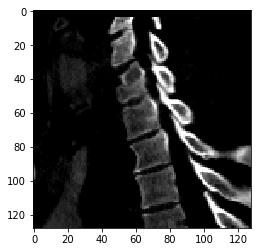

In [36]:
import matplotlib.pyplot as plt
plt.imshow(d[0,:,:,64,0], cmap='gray')

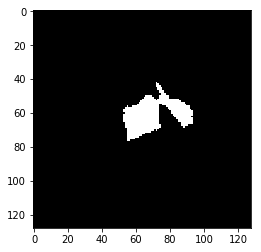

In [37]:
plt.imshow(w[0,:,:,64,0], cmap='gray')

In [33]:
x = np.load('./data')

IsADirectoryError: [Errno 21] Is a directory: './data'